In [3]:
# ------------------------------------------------------------------
# 0. Imports and Setup
# ------------------------------------------------------------------
import os
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

try:
    import chainconsumer, seaborn, emcee, arviz
except:
    print('Installing Non-Default Packages...')
    os.system('pip install seaborn')
    os.system('pip install emcee')
    os.system('pip install chainconsumer')
    os.system('pip install arviz')

# It's good practice to manage your python path this way
# Create a 'scat_analysis' directory for your code if you haven't already
# and place this notebook outside of it.
# e.g., /path/to/project/notebook.ipynb
#       /path/to/project/scat_analysis/__init__.py
#       /path/to/project/scat_analysis/burstfit_pipeline.py
#       ...
# This makes imports clean and explicit.
# If your project root is not in the path, uncomment the following line:
# sys.path.insert(0, '/path/to/your/project/root')

# Use ipython magic for interactive development
%load_ext autoreload
%autoreload 2

# --- Core Pipeline Import ---
from scat_analysis.burstfit_pipeline import BurstPipeline

# --- Interactive Post-processing Imports ---
# These are for optional, interactive analysis after the main run.
from scat_analysis.burstfit_corner import (
    quick_chain_check,
    get_clean_samples,
    make_beautiful_corner,
    make_beautiful_corner_wide
)
from scat_analysis.burstfit import FRBParams

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# ------------------------------------------------------------------
# 1. Configuration
# ------------------------------------------------------------------
# --- Locate data file ---
burst_name = "casey" # Name of the burst to analyze
data_dir = Path("/arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts")
data_dir_parent = data_dir.parent
plot_dir = os.path.join(data_dir_parent, "plot")

# Use pathlib for robust path handling
try:
    data_path = next(data_dir.glob(f"*{burst_name}*.npy"))
    print(f"Found data file: {data_path}")
except StopIteration:
    raise FileNotFoundError(f"No .npy file containing '{burst_name}' found in {data_dir}")

# --- Set Telescope and Run Parameters ---
# These parameters will be passed directly to the pipeline
pipeline_config = {
    "telescope": "dsa",
    "telcfg_path": "yaml/telescopes.yaml",
    "sampcfg_path": "yaml/sampler.yaml",
    "steps": 1000,          # Total MCMC steps for the final run
    "f_factor": 384,        # Downsampling factor in frequency
    "t_factor": 2,          # Downsampling factor in time
    "center_burst": True,
    "outer_trim": 0.49,
    "smooth_ms": 0.1,
    "nproc": 16,             # Number of processes for multiprocessing
    "yes": True,            # Auto-confirm pool creation
}

Found data file: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/casey_dsa_I_491_211_2500b_cntr_bpc.npy


In [5]:
# --- Set Initial Dispersion Measure ---
dm_initial = 0.0 # pc cm^-3

# ------------------------------------------------------------------
# 2. Build and Run the Pipeline
# ------------------------------------------------------------------
# The pipeline is instantiated with all configuration parameters.
# The `with` statement ensures the multiprocessing pool is handled correctly.
pipe = BurstPipeline(
    path=data_path,
    dm_init=dm_initial,
    **pipeline_config
)


[BurstFit] running with nproc=16


In [6]:
# This single call now performs all the steps:
# - Data loading and preprocessing
# - Finding an optimized initial guess
# - Running the model selection scan (or a direct fit)
# - Processing the MCMC chains
# - Running all diagnostics (sub-band, influence, etc.)
# - Calculating goodness-of-fit
# - Generating and saving the 16-panel summary plot
results = pipe.run_full(
    model_scan=True,      # Perform BIC scan over models M0-M3
    model_keys=["M1", "M3"],
    diagnostics=True,     # Run all post-fit diagnostic checks
    plot=True,            # Generate and save the summary plot
    show=False            # Do not block execution with plt.show()
    
)


[INFO | burstfit.pipeline] Finding initial guess for MCMC...
[INFO | burstfit.pipeline] Refined initial guess found via optimization.
[INFO | burstfit.pipeline] Starting model selection scan (BIC)...
100%|██████████| 250/250 [00:01<00:00, 158.86it/s]


[Model M1]  logL_max = -25387.2 | BIC =  50798.4


100%|██████████| 250/250 [00:02<00:00, 124.28it/s]
[INFO | burstfit.pipeline] Processing MCMC chains...
[INFO | burstfit.pipeline] Auto-determined burn-in: 105, thinning: 11
[INFO | burstfit.pipeline] Running all post-fit diagnostics...


[Model M3]  logL_max = -41804.1 | BIC =  83638.1

→ Best model by BIC: M1


100%|██████████| 125/125 [00:00<00:00, 200.64it/s]
[INFO | burstfit.pipeline] Diagnostics complete.
[INFO | burstfit.pipeline] Best model: M1 | χ²/dof = 128.22
[INFO | burstfit.pipeline] Generating 16-panel comprehensive diagnostics plot...
[INFO | burstfit.pipeline] Generating four-panel diagnostic plot...
[INFO | burstfit.pipeline] Saving 4-panel plot to /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/casey_dsa_I_491_211_2500b_cntr_bpc_fullmodel.pdf



--- Pipeline Run Summary ---
Best model found: M1
Reduced Chi-squared: 126.53
Best-fit parameters (from highest-likelihood sample):
FRBParams(c0=0.2999344776959601, t0=0.7604887352795443, gamma=-1.2837175410245365, zeta=0.024782503074295983, tau_1ghz=0.0)

--- Interactive Chain Convergence Check ---
Chain Health Check:
  Log-prob stability: 1.67 (want < 1.0)
  Parameter drift: 0.05 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)

Chain not fully converged. Running for 1000 more steps...


100%|██████████| 1000/1000 [00:04<00:00, 240.41it/s]


Chain Health Check:
  Log-prob stability: 1.64 (want < 1.0)
  Parameter drift: 0.07 (want < 0.1)
  ⚠️  Chains may need more steps!
  Consider running: sampler.run_mcmc(None, 1000, progress=True)
Reached max extra steps (1000); proceeding.

--- Generating Final Corner Plot ---
Detected burn-in: 339 steps


[WARNING | emcee.autocorr] The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 175;
tau: [161.28580829  82.3289426  301.29034916 114.77876728]


Using thinning: 20
Final samples: 13440 (from 279680 total)
Removed 14 outlier samples

Parameter Summary (median [16%, 84%]):
c0: 0.300 [0.300, 0.300]
t0: 0.758 [0.756, 0.760]
gamma: 3.159 [3.089, 3.190]
zeta: 0.018 [0.013, 0.021]
Saved corner plot to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/casey_dsa_I_491_211_2500b_cntr_bpc_corner.png


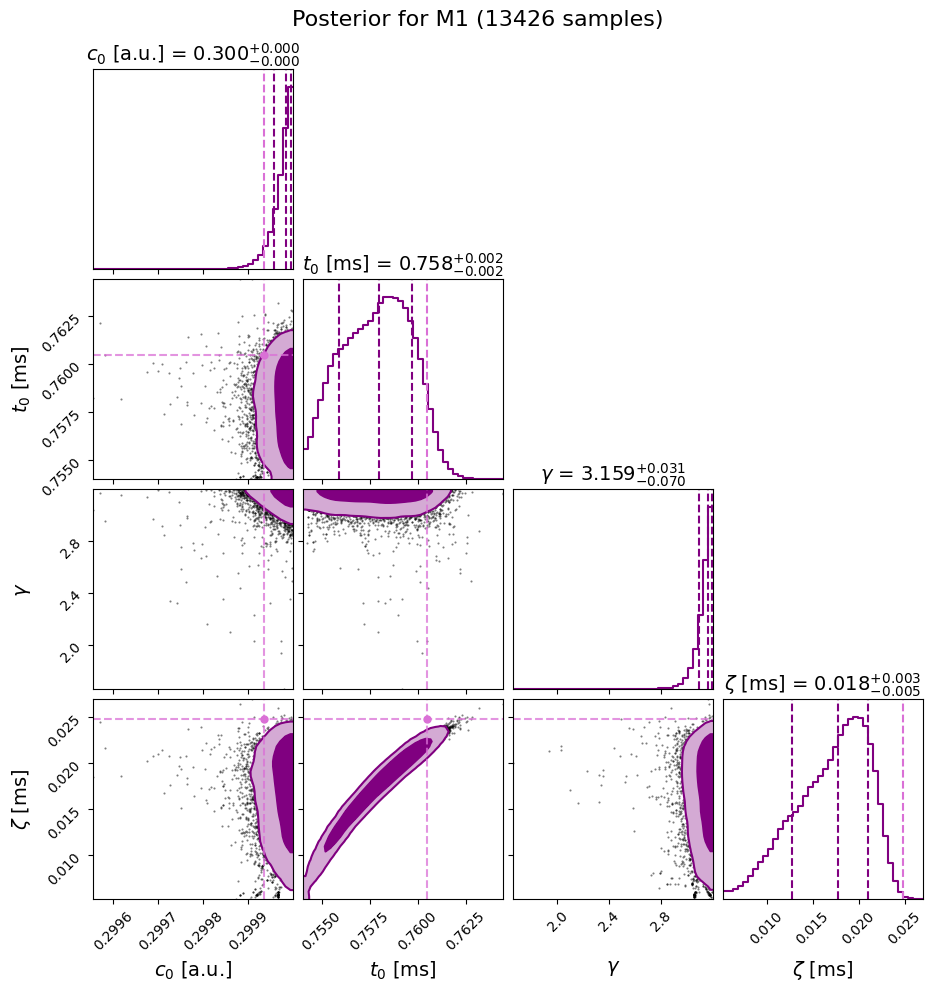

TypeError: make_beautiful_corner_wide() got multiple values for argument 'best_params'

In [61]:
# The main results are in the returned dictionary. Let's look at them.
print("\n--- Pipeline Run Summary ---")
print(f"Best model found: {results['best_key']}")
print(f"Reduced Chi-squared: {results['goodness_of_fit']['chi2_reduced']:.2f}")
print("Best-fit parameters (from highest-likelihood sample):")
print(results['best_params'])


# ------------------------------------------------------------------
# 3. Interactive Post-Fit Analysis (Optional)
# ------------------------------------------------------------------
# The main pipeline has already produced a full analysis. The following
# steps are useful for interactively assessing convergence and creating
# custom plots like a detailed corner plot.

sampler = results["sampler"]
best_p = results["best_params"]
param_names = results["param_names"]

# --- FIX: Detach the sampler from the now-closed pool ---
# By setting the pool to None, subsequent calls will run in serial mode.
sampler.pool = None 

# --- Interactively extend the chain until convergence ---
print("\n--- Interactive Chain Convergence Check ---")
max_extra_chunks, chunk_size = 2, 1000 
chunks_added = 0
while not quick_chain_check(sampler):
    if chunks_added >= max_extra_chunks:
        print(f"Reached max extra steps ({max_extra_chunks * chunk_size}); proceeding.")
        break
    print(f"\nChain not fully converged. Running for {chunk_size} more steps...")
    # This call will now work correctly
    sampler.run_mcmc(None, chunk_size, progress=True)
    chunks_added += 1

# --- Generate a high-quality corner plot with the final chain ---
print("\n--- Generating Final Corner Plot ---")
final_clean_samples = get_clean_samples(sampler, param_names, verbose=True)

#fig_corner = make_beautiful_corner(
#    final_clean_samples,
#    param_names,
#    best_params=best_p,
#    title=f"Posterior for {results['best_key']} ({final_clean_samples.shape[0]} samples)"
#)
#
## Save and display the final corner plot
#corner_path = data_path.with_name(f"{data_path.stem}_corner.pdf")
#fig_corner.savefig(corner_path, dpi=200, bbox_inches="tight")
#print(f"Saved corner plot to: {corner_path}")
#plt.show()
#
#fig_corner = make_beautiful_corner_wide(
#    final_clean_samples,
#    param_names,
#    best_params=best_p,
#    title=f"Posterior for {results['best_key']} ({final_clean_samples.shape[0]} samples)"
#)

# Save and display the final corner plot
corner_path = data_path.with_name(f"{plot_dir}/{burst_name}_scat_corner.pdf")
fig_corner.savefig(corner_path)
print(f"Saved corner plot to: {corner_path}")
plt.show()

# The 4-panel plot is now generated automatically by the pipeline's
# `create_sixteen_panel_plot` or `create_four_panel_plot` functions,
# so the manual plotting code from the old notebook is no longer needed here.

print("\nAnalysis complete.")



Parameter Summary (median [16%, 84%]):
c0: 0.300 [0.300, 0.300]
t0: 0.758 [0.756, 0.760]
gamma: 3.159 [3.089, 3.190]
zeta: 0.018 [0.013, 0.021]
Saved corner plot to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/casey_dsa_I_491_211_2500b_cntr_bpc_corner.png


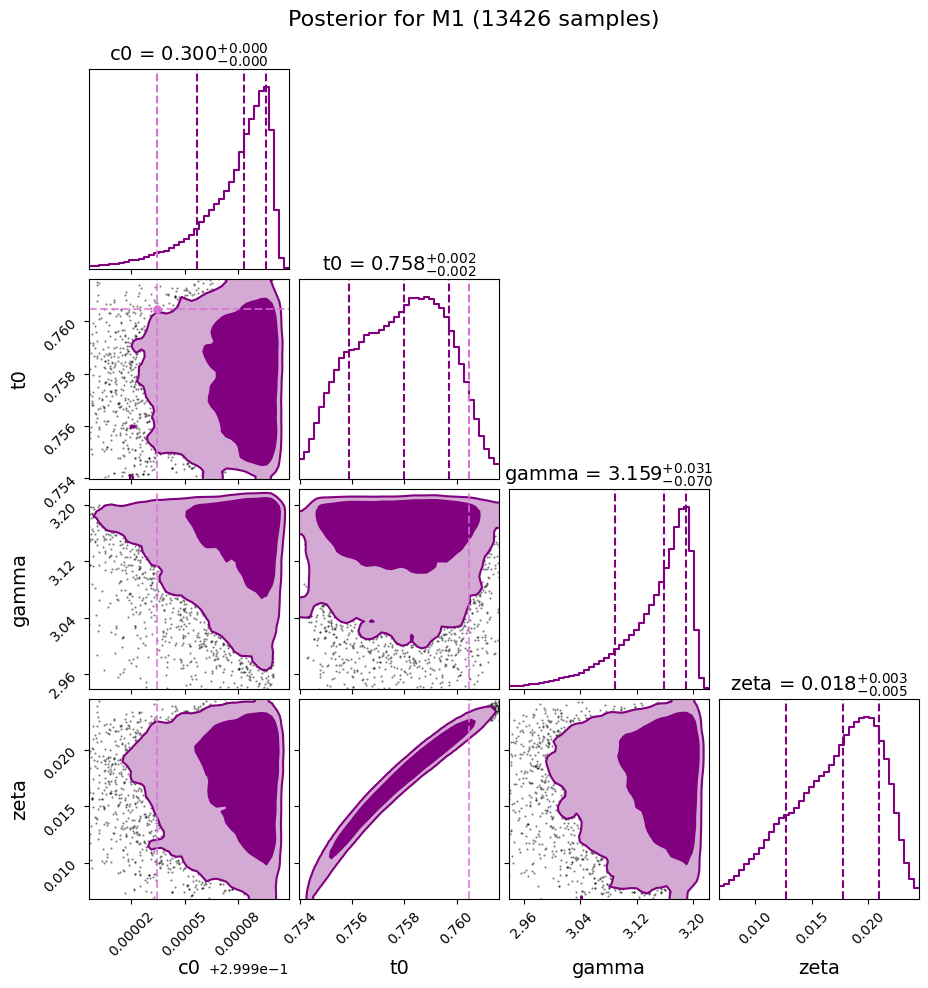


Analysis complete.


[WARNING | emcee.autocorr] The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 105;
tau: [158.99136509  81.95801752 285.77611628 113.13133469]


Detected burn-in: 339 steps
Using thinning: 20
Final samples: 7840 (from 168000 total)
Removed 8 outlier samples


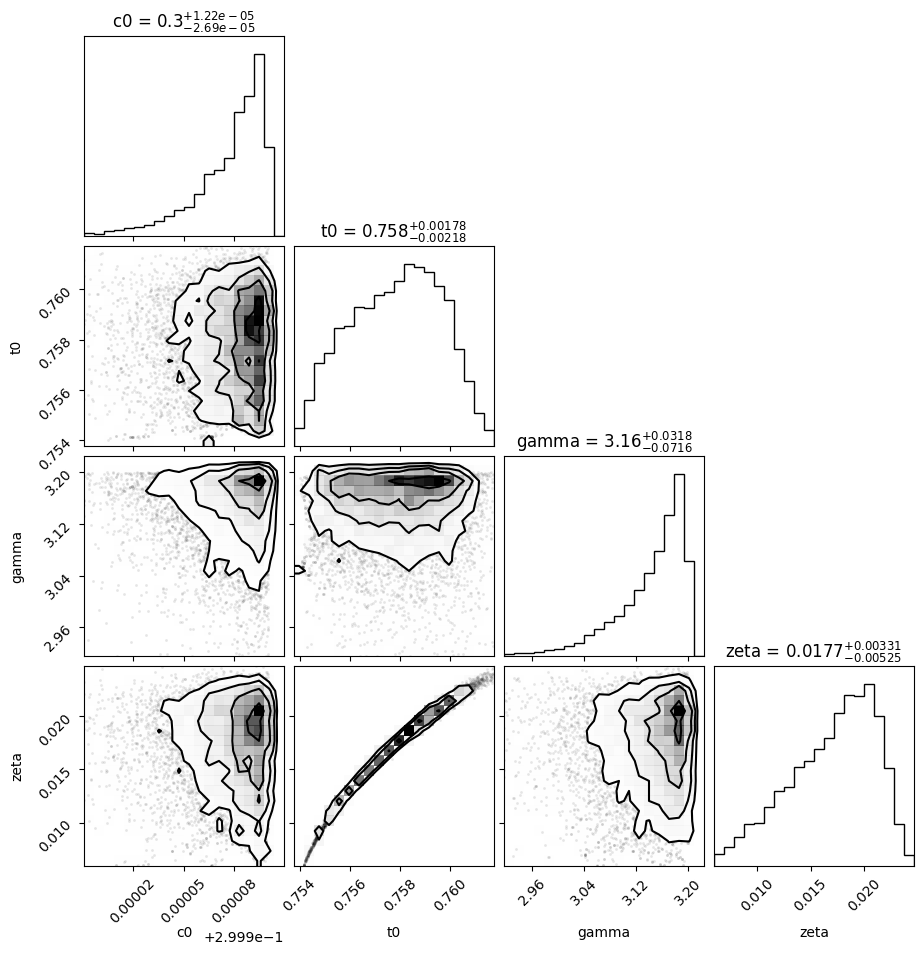

In [53]:
import corner, numpy as np
samples = get_clean_samples(sampler, param_names, verbose=True)
q   = np.percentile(samples, [2, 98], axis=0)      # loose 96 % band
pad = 0.1 * (q[1] - q[0])                          # 10 % breathing room
ranges = [(low - d, high + d) for (low, high), d in zip(q.T, pad)]

fig = corner.corner(samples, labels=param_names, range=ranges,
                    show_titles=True, title_fmt=".3g", max_n_ticks=4)


Parameter Summary (median [16%, 84%]):
c0: 0.300 [0.300, 0.300]
t0: 0.758 [0.756, 0.760]
gamma: 3.154 [3.059, 3.189]
zeta: 0.018 [0.013, 0.022]
Saved corner plot to: /arc/home/jfaber/baseband_morphologies/chime_dsa_codetections/data/DSA_bursts/casey_dsa_I_491_211_2500b_cntr_bpc_corner.png


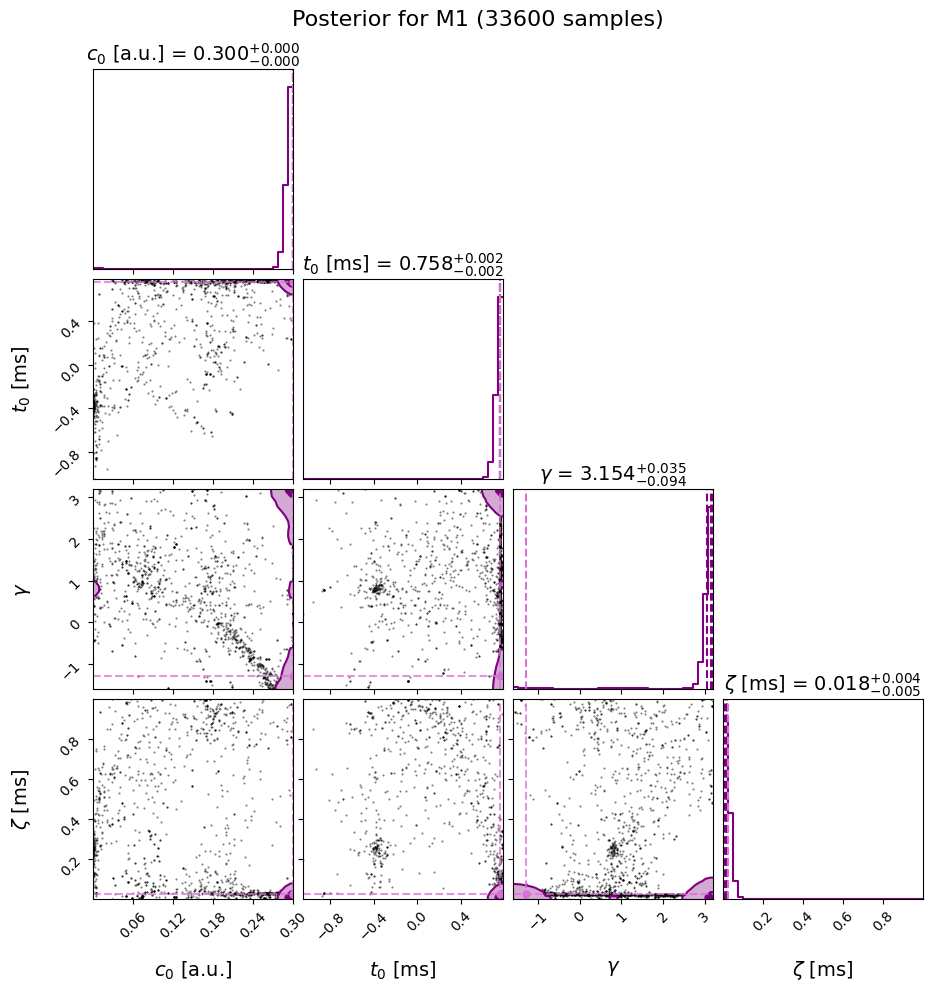

In [50]:
final_clean_samples = sampler.get_chain(discard=0, thin=5, flat=True)
fig_corner = make_beautiful_corner(
    final_clean_samples,
    param_names,
    best_params=best_p,
    title=f"Posterior for {results['best_key']} ({final_clean_samples.shape[0]} samples)"
)

# Save and display the final corner plot
corner_path = data_path.with_name(f"{data_path.stem}_corner.pdf")
fig_corner.savefig(corner_path, dpi=200, bbox_inches="tight")
print(f"Saved corner plot to: {corner_path}")
plt.show()

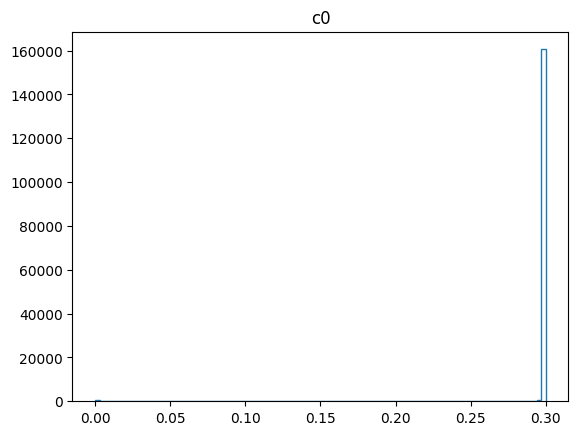

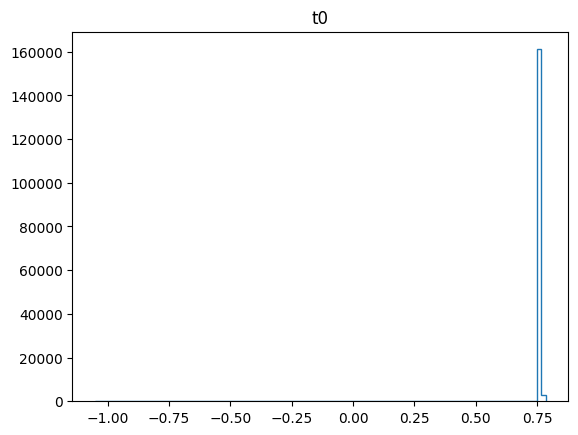

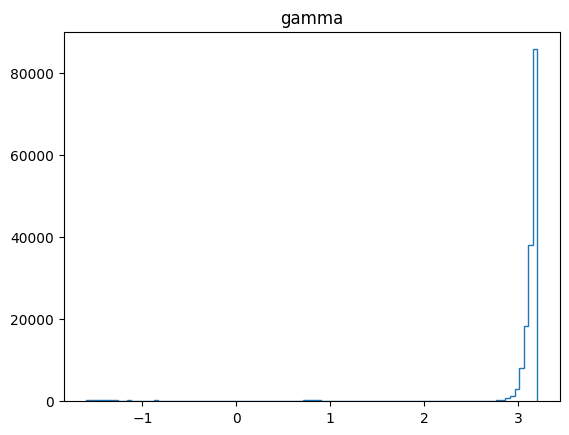

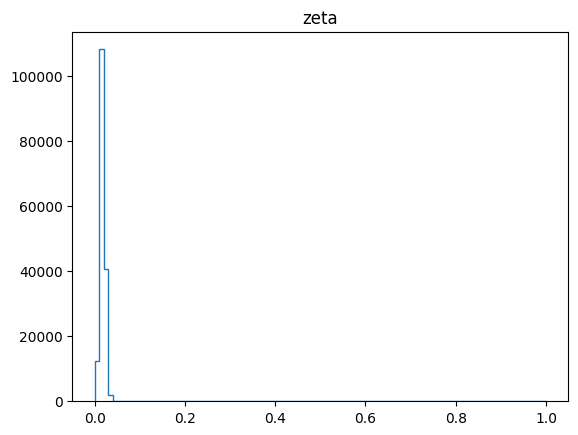

In [49]:
import numpy as np, matplotlib.pyplot as plt
chain = sampler.get_chain(discard=0, flat=True)   # no burn-in removal yet
for i, name in enumerate(param_names):
    plt.figure(); plt.hist(chain[:, i], 100, histtype="step"); plt.title(name)
